In [1]:
from ultralytics import YOLO
import torch
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import easyocr
from matplotlib.path import Path as mplPath
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4080 SUPER'

In [9]:
#Images sourced from the internet for testing deployed model:
car_model = YOLO("best9.pt",task='detect')
char_model = YOLO("char_weights.pt",task='detect')
image_files = ["tests/Test_Model_1.jpeg", "tests/Test_Model_2.jpeg", "tests/Test_Model_3.jpeg", 
               "tests/Test_Model_4.jpeg", "tests/Test_Model_5.jpeg", "tests/Test_Model_6.jpeg"]

In [10]:
def extract_rois(results, target_label="Placa"):
    rois = []
    coordinates = []
    for result in results:
        for box in result.boxes:
            # Check if the detected object is a license plate (label: "Placa")
            if car_model.names[int(box.cls)] == target_label:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                roi = result.orig_img[y1:y2, x1:x2]  # Extract the ROI
                rois.append(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))  # Convert to RGB
                coordinates.append([x1, y1, x2, y2])
    return rois, coordinates

In [23]:
def preprocess_plate(roi):
    # Convert ROI to grayscale
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    
    # Apply GaussianBlur to reduce noise
    blurred = cv2.GaussianBlur(gray_roi, (5, 5), 0)
    
    # Apply Otsu's binarization
    _, binarized_roi = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return binarized_roi


0: 384x640 3 Autos, 2 Placas, 10.2ms
Speed: 9.1ms preprocess, 10.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


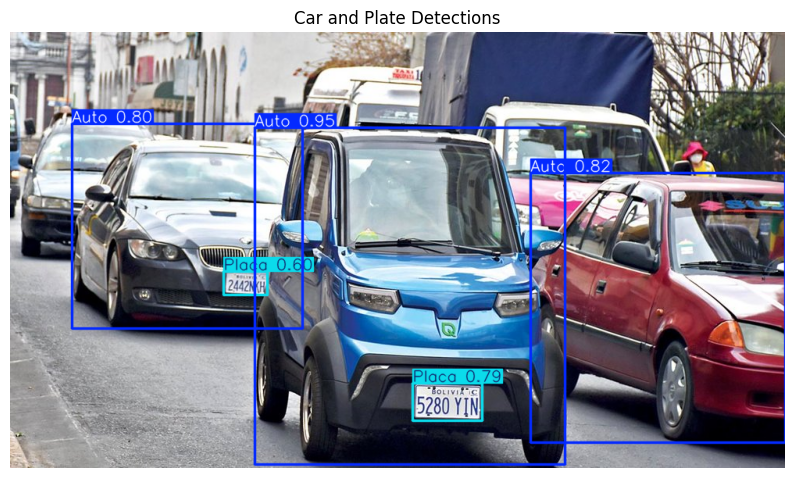

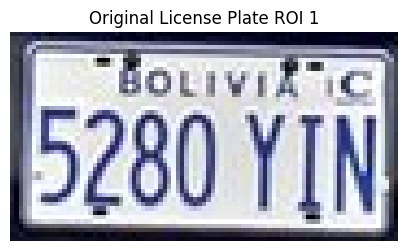

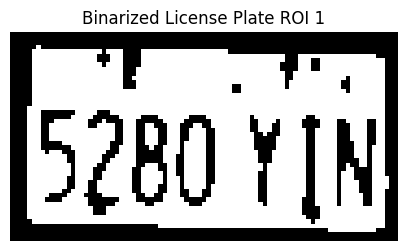


0: 352x640 1 1, 1 2, 1 5, 1 D, 10.3ms
Speed: 0.5ms preprocess, 10.3ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)
Detected characters on plate 1: 152D


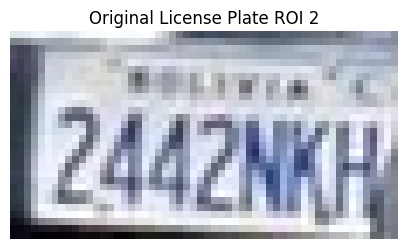

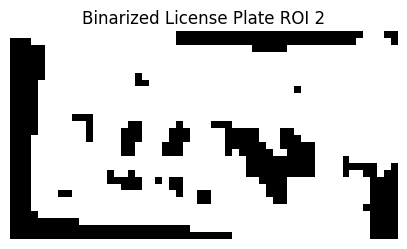


0: 352x640 (no detections), 9.4ms
Speed: 0.5ms preprocess, 9.4ms inference, 0.2ms postprocess per image at shape (1, 3, 352, 640)
Detected characters on plate 2: 

0: 384x640 1 Auto, 1 Placa, 9.6ms
Speed: 0.9ms preprocess, 9.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


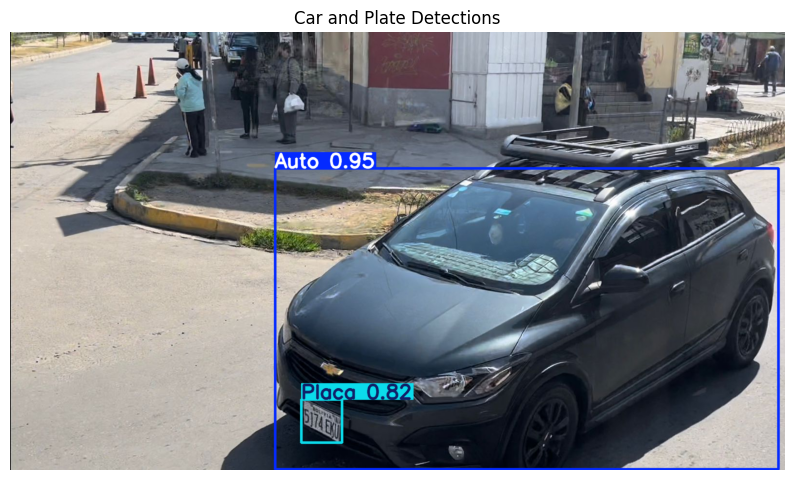

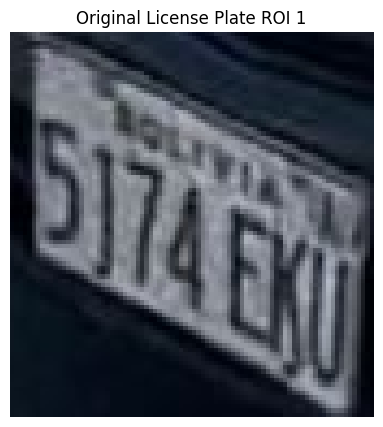

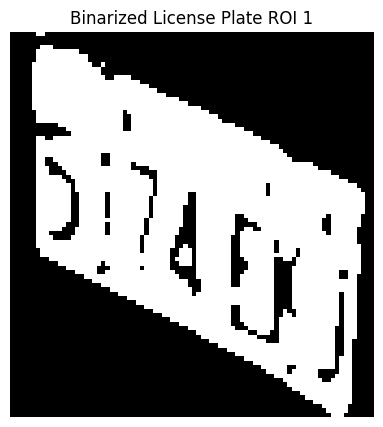


0: 640x608 (no detections), 13.0ms
Speed: 0.8ms preprocess, 13.0ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 608)
Detected characters on plate 1: 

0: 384x640 1 Auto, 1 Placa, 9.5ms
Speed: 0.8ms preprocess, 9.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


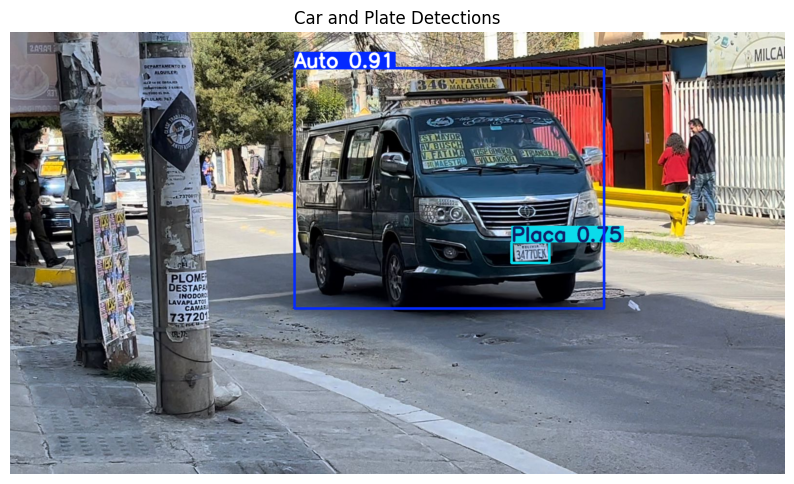

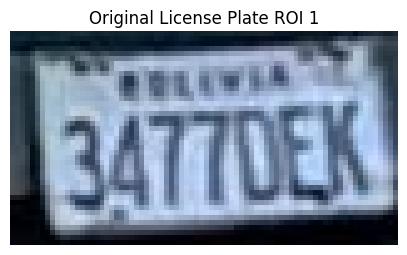

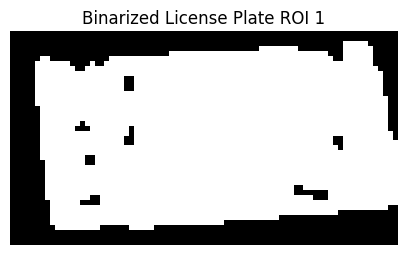


0: 384x640 (no detections), 10.2ms
Speed: 0.6ms preprocess, 10.2ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 640)
Detected characters on plate 1: 

0: 384x640 2 Autos, 1 Placa, 9.5ms
Speed: 0.9ms preprocess, 9.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


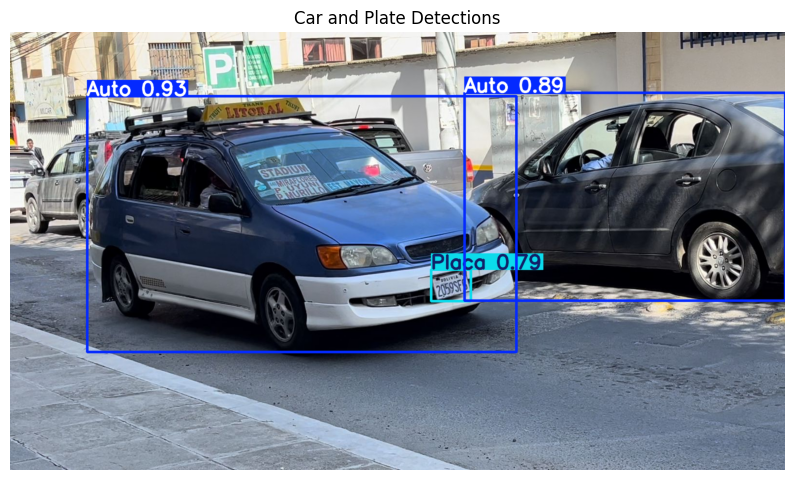

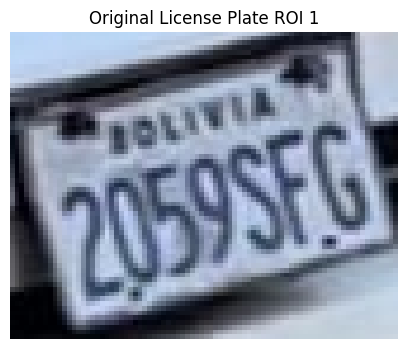

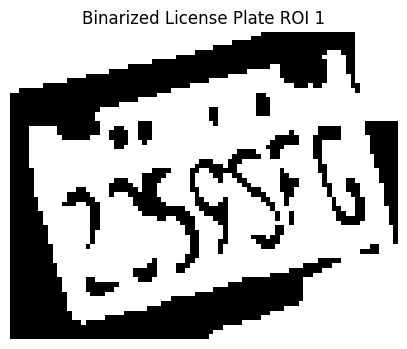


0: 512x640 2 3s, 10.2ms
Speed: 0.7ms preprocess, 10.2ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)
Detected characters on plate 1: 33

0: 384x640 2 Autos, 1 Placa, 9.4ms
Speed: 0.9ms preprocess, 9.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


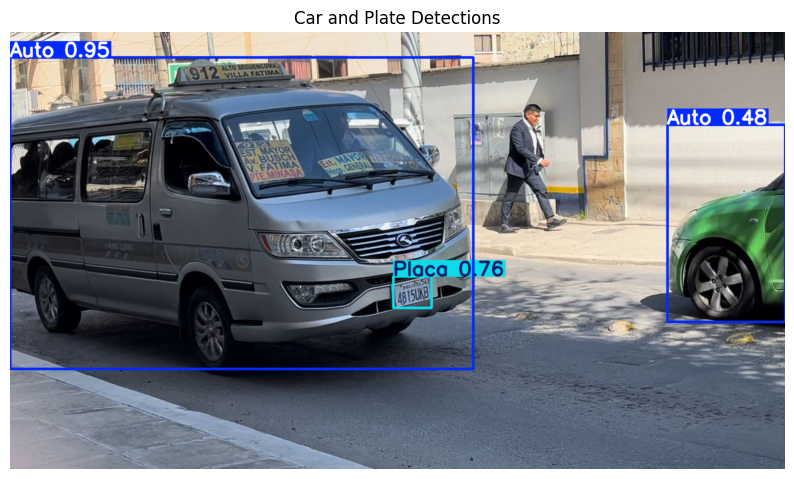

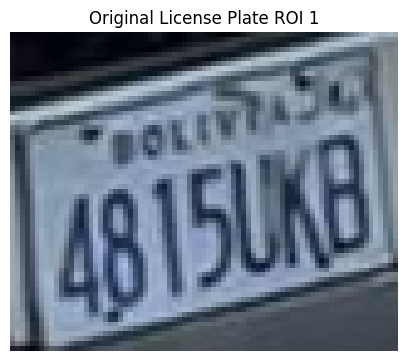

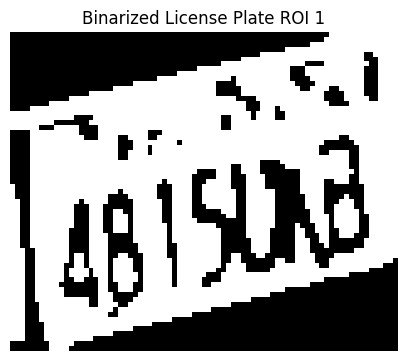


0: 544x640 1 1, 1 4, 1 5, 12.7ms
Speed: 0.7ms preprocess, 12.7ms inference, 0.4ms postprocess per image at shape (1, 3, 544, 640)
Detected characters on plate 1: 145

0: 384x640 1 Auto, 1 Placa, 9.1ms
Speed: 0.9ms preprocess, 9.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


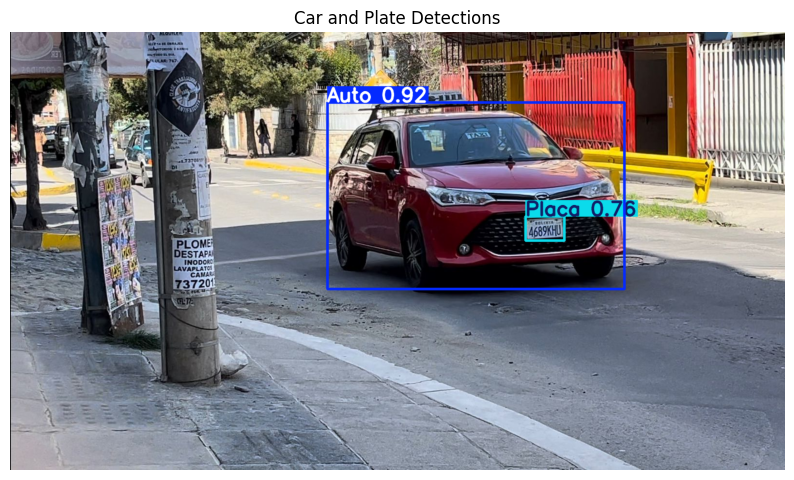

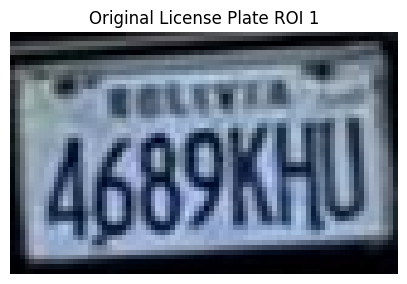

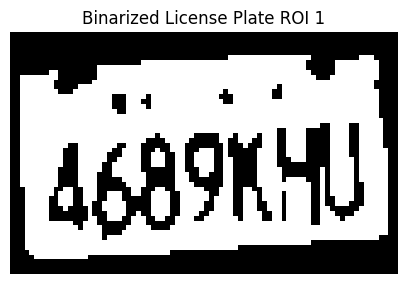


0: 416x640 1 4, 1 6, 1 8, 1 H, 9.8ms
Speed: 0.6ms preprocess, 9.8ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)
Detected characters on plate 1: 684H


In [27]:
for img_path in image_files:
    # Read the image using OpenCV
    img = cv2.imread(img_path)
    
    # Run inference with the car_model to detect cars and plates
    results = car_model(img)
    
    # Display the car and plate detections
    for result in results:
        img_with_detections = result.plot()  # This draws bounding boxes and labels

        # Convert the image to RGB and display
        img_rgb = cv2.cvtColor(img_with_detections, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 10))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title("Car and Plate Detections")
        plt.show()
    
    # Extract ROIs for license plates
    plate_rois, plate_coords = extract_rois(results, target_label="Placa")
    
    # If any license plates are detected
    if plate_rois:
        for i, roi in enumerate(plate_rois):
            # Display the extracted license plate ROI before preprocessing
            plt.figure(figsize=(5, 5))
            #plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
            plt.imshow(roi)
            plt.axis('off')
            plt.title(f"Original License Plate ROI {i+1}")
            plt.show()

            # Preprocess the plate ROI with Otsu's binarization
            binarized_plate = preprocess_plate(roi)

            # Display the binarized license plate ROI
            plt.figure(figsize=(5, 5))
            plt.imshow(binarized_plate, cmap='gray')
            plt.axis('off')
            plt.title(f"Binarized License Plate ROI {i+1}")
            plt.show()

            # Convert the binarized image back to 3-channel (RGB) format for YOLO input
            binarized_plate_rgb = cv2.cvtColor(binarized_plate, cv2.COLOR_GRAY2RGB)

            # Run inference with the char_model on the binarized plate ROI to detect characters
            char_results = char_model(binarized_plate_rgb)

            # Print the detected characters from char_model
            detected_chars = []
            for char_result in char_results:
                for box in char_result.boxes:
                    # Assuming the class for characters is correctly labeled
                    detected_chars.append(char_model.names[int(box.cls)])
            
            # Join and print the detected characters
            print(f"Detected characters on plate {i + 1}: {''.join(detected_chars)}")
    else:
        print(f"No license plates found in {img_path}.")